# Regresión Logística

En éste notebook desarrollaremos e implementaremos el algoritmo de regresión logística, usando el conjunto de datos *Medical Insurance Cost Prediction*.
___

In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as op
import math
import matplotlib.pyplot as plt
import seaborn as sns

## Análisis de los datos

El conjunto de datos está enfocado a la predicción del coste del seguro médico, y nos brinda 54 características con las que operar.

[En ésta página web](https://www.kaggle.com/datasets/mohankrishnathalla/medical-insurance-cost-prediction/data) podremos ver en profundidad qué representan las distintas características.

En resumen, éstas pueden condensarse en 6 grupos:

1. Demográficas y Socioeconómicas.
2. Estilo de vida y hábitos.
3. Salud y datos clínicos.
4. Uso del seguro médico y procedimientos utilizados.
5. Seguro y Políticas.
6. Costes médicos y pagos.

Carguemos los datos y echémosles un vistazo:

In [2]:
data = pd.read_csv('./medical_insurance.csv', index_col='person_id')
data.head()

,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,dependents,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
person_id,,,,,,,,,,,,,,,,,,,,,
75722,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,1,...,0,1,0,1,0,2,0,1,0,0
80185,79,Female,North,Urban,12800.0,No HS,Married,Employed,3,1,...,0,1,1,0,0,1,0,1,1,0
19865,68,Male,North,Rural,40700.0,HS,Married,Retired,5,3,...,0,0,1,1,0,2,1,0,1,0
76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,3,...,0,0,0,1,0,0,1,0,0,0
92992,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,0,...,0,1,0,2,0,1,1,0,1,0


### Correlación


___
### Incongruencias y/o valores problemáticos
Antes de operar con el conjunto de datos, debemos hacer un análisis del mismo, en busca de datos problemáticos que puedan afectar a la calidad de nuestros modelos.

#### Problemas específicos de columna

##### Edad (18 a 90 años)
Con una simple comprobación, podemos ver cómo existen valores fuera de la franja de edad establecida.

Menores de 18:

In [3]:
dataAux = data[data.age < 18] # Usaremos ésta variable datosAux para comprobaciones, no para operar
dataAux.head()

,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,dependents,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
person_id,,,,,,,,,,,,,,,,,,,,,
76700,15,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,3,...,0,0,0,1,0,0,1,0,0,0
576,12,Male,Central,Suburban,52500.0,Masters,Divorced,Employed,2,1,...,0,0,0,0,0,1,0,0,0,0
30713,10,Female,South,Urban,69000.0,Some College,Single,Employed,3,2,...,0,0,0,1,0,0,1,1,0,0
13800,6,Female,West,Suburban,57600.0,Some College,Married,Self-employed,2,0,...,0,0,0,1,0,0,1,0,0,0
3232,15,Male,West,Suburban,48200.0,Bachelors,Single,Retired,3,2,...,0,0,0,1,0,1,0,1,0,0


Mayores de 90:

In [4]:
dataAux = data[data.age > 90]
dataAux.head()

,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,dependents,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
person_id,,,,,,,,,,,,,,,,,,,,,
42222,91,Female,East,Suburban,32700.0,No HS,Married,Employed,3,1,...,0,0,0,1,0,1,0,1,1,0
33076,96,Female,East,Suburban,78900.0,HS,Married,Unemployed,4,2,...,0,0,1,0,0,0,2,1,1,1
65644,93,Male,East,Suburban,64100.0,Masters,Widowed,Employed,3,2,...,0,0,1,0,0,0,2,1,1,0
8312,91,Female,South,Suburban,209700.0,Bachelors,Single,Retired,2,1,...,0,1,0,0,0,0,0,0,1,0
67703,91,Male,North,Urban,11000.0,Bachelors,Married,Self-employed,2,0,...,0,0,0,0,0,2,0,1,1,0


En un principio, **para aquellos pacientes de más de 90 años, no tendríamos mayor problema**, simplemente se han salido del rango.

Sin embargo, **para aquellos pacientes menores a 18 años, las incongruencias son evidentes**: Algunos están supuestamente casados o divorciados y hasta empleados o retirados.

Por tanto, **debemos sanear éstos datos** en caso de que queramos usarlos. Para ello, tendríamos **diferentes métodos**:
1. **Elevar la edad hasta el mínimo de 18 años**: Es la vía más fácil, pero en muchos casos seguiría siendo insuficiente para mantener consistencia en los datos.
2. **Sustituir la edad de éstos pacientes a la media o mediana de todos los pacientes**: Permite una aproximación más cercana a la realidad que el método anterior, pero seguiría habiendo casos incongruentes. Por ejemplo, si la media o mediana fuesen 35 años, habría pacientes retirados a esa edad.
3. **Sustituir la edad de éstos pacientes por la media o mediana del resto de pacientes con el mismo estado civil y/o laboral**: Ésto permite una mejor aproximación a la realidad, ya que estaríamos aproximando las edades en base a los datos de pacientes parecidos. Con éste método, nos aseguramos tener muchas menos incongruencias que con los métodos anteriores.
4. **Sustituir en base a otras características comunes**: Lo mismo que el punto anterior, pero cambiando de características

Vamos a usar el tercer método con el estado civil para sanear éstos problemas:


In [5]:
unique_marital_status = data.marital_status.unique()
unique_employment_status = data.employment_status.unique()
status_avg = {};
# Determinamos los valores medios de cada grupo.
for marital_status in unique_marital_status:
    status_avg[marital_status] = {}
    for employment_status in unique_employment_status:
        mean = data[(data.marital_status == marital_status) & (data.employment_status == employment_status)].age.mean();
        # Imprimo en double para comprobar que no estamos
        # haciendo nada mal, pese a dar valores super parecidos:
        print("Promedio de", marital_status, ",", employment_status, ":", mean)
        status_avg[marital_status][employment_status] = int(mean)


Promedio de Married , Retired : 47.691068400226115
Promedio de Married , Employed : 47.56931721437085
Promedio de Married , Self-employed : 47.33412172816146
Promedio de Married , Unemployed : 47.55836098687058
Promedio de Single , Retired : 47.63596920923723
Promedio de Single , Employed : 47.358408202629306
Promedio de Single , Self-employed : 47.65507584597433
Promedio de Single , Unemployed : 47.5043630017452
Promedio de Divorced , Retired : 47.79642058165548
Promedio de Divorced , Employed : 47.187691521961185
Promedio de Divorced , Self-employed : 47.855582524271846
Promedio de Divorced , Unemployed : 48.48947951273533
Promedio de Widowed , Retired : 47.09424083769633
Promedio de Widowed , Employed : 47.59422824661128
Promedio de Widowed , Self-employed : 46.924528301886795
Promedio de Widowed , Unemployed : 47.26103646833013


Aquí tenemos **algo muy inusual**. **Las medias** de éstos grupos **se parecen muchísimo**, incluso entre grupos como "Single, Employed" y "Married,Retired", que deberían de tener promedios muy distintos.

Ésto es una **prueba bastante clara de que éstos datos son sintéticos**: han sido generados por un algoritmo. Por tanto, **no debemos de fiarnos mucho de los resultados que nos dé el modelo**, ya que **no estarán basados en datos reales**.
Igualmente, intentaremos que el modelo sea de calidad, aunque sea sobre sus propios valores sintéticos.

Volviendo con la implementación, voy a crear una función que haga de "máscara" para poder sustituir los valores que están mal. Básicamente, sólo va a seleccionar los datos que den un "true" por la máscara. 
En éste caso, queremos dar un true en caso de que el menor tenga un estado civil distinto de soltero y/o que su estado laboral no sea desempleado:

In [6]:
def esInconsistente(linea):
    if linea.age < 18:
        if linea.marital_status != 'Single':
            return True
        elif linea.employment_status != 'Unemployed':
            return True
    return False

Aplicamos los cambios:

In [7]:
# Guardamos una serie booleana con la que decidiremos
# si todo esta ok o no
mascara = data.apply(esInconsistente, axis=1)

# En base a la máscara, hacemos cambios
data.loc[mascara, 'age'] = data[mascara].apply(
    lambda linea: status_avg[linea['marital_status']][linea['employment_status']], 
    axis=1
)

data.head()

,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,dependents,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
person_id,,,,,,,,,,,,,,,,,,,,,
75722,52,Female,North,Suburban,22700.0,Doctorate,Married,Retired,3,1,...,0,1,0,1,0,2,0,1,0,0
80185,79,Female,North,Urban,12800.0,No HS,Married,Employed,3,1,...,0,1,1,0,0,1,0,1,1,0
19865,68,Male,North,Rural,40700.0,HS,Married,Retired,5,3,...,0,0,1,1,0,2,1,0,1,0
76700,47,Male,North,Suburban,15600.0,Some College,Married,Self-employed,5,3,...,0,0,0,1,0,0,1,0,0,0
92992,53,Male,Central,Suburban,89600.0,Doctorate,Married,Self-employed,2,0,...,0,1,0,2,0,1,1,0,1,0


___
##### Paciente de alto riesgo y puntuación de riesgo
Las características "Paciente de alto riesgo" (*is_high_risk*) y "Puntuación de riesgo" (*risk_score*) están estrechamente relacionadas.

La primera, *is_high_risk*, indica de forma binaria con un 1 si el paciente es de alto riesgo, y con un 0 el caso contrario.
La segunda, *risk_score*, indica la puntuación (normalizada) de un paciente de ser de alto riesgo. Al estar normalizada, podemos interpretar dicha columna como "la probabilidad de que el paciente sea o pase a ser de alto riesgo".

Por tanto, podríamos pensar que no tiene sentido que un paciente tenga un 100% de probabilidades de ser de alto riesgo y que aún no lo sea.

Echémos un vistazo:

In [8]:
dataAux = data.loc[(data.is_high_risk == 0) & (data.risk_score == 1)]
dataAux.head()

,age,sex,region,urban_rural,income,education,marital_status,employment_status,household_size,dependents,...,liver_disease,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure
person_id,,,,,,,,,,,,,,,,,,,,,


Por tanto, podemos estar tranquilos: No hay paciente que haya sacado el máximo *risk_score* que no se haya catalogado como *is_high_risk = 1*.

___
#### Problemas generales
##### Valores nulos

Miremos que no existen valores nulos ni NaN dentro del dataset:

In [9]:
colNames = data.columns
colsNullNaN = []
print(colNames)
for col in colNames:
    if data[col].isnull().values.any():
        colsNullNaN.append(col)

print('Columnas con valores nulos o NaN:', colsNullNaN)

Index(['age', 'sex', 'region', 'urban_rural', 'income', 'education',
       'marital_status', 'employment_status', 'household_size', 'dependents',
       'bmi', 'smoker', 'alcohol_freq', 'visits_last_year',
       'hospitalizations_last_3yrs', 'days_hospitalized_last_3yrs',
       'medication_count', 'systolic_bp', 'diastolic_bp', 'ldl', 'hba1c',
       'plan_type', 'network_tier', 'deductible', 'copay', 'policy_term_years',
       'policy_changes_last_2yrs', 'provider_quality', 'risk_score',
       'annual_medical_cost', 'annual_premium', 'monthly_premium',
       'claims_count', 'avg_claim_amount', 'total_claims_paid',
       'chronic_count', 'hypertension', 'diabetes', 'asthma', 'copd',
       'cardiovascular_disease', 'cancer_history', 'kidney_disease',
       'liver_disease', 'arthritis', 'mental_health', 'proc_imaging_count',
       'proc_surgery_count', 'proc_physio_count', 'proc_consult_count',
       'proc_lab_count', 'is_high_risk', 'had_major_procedure'],
      dtype='object

In [10]:
data[data['alcohol_freq'].isnull()]['alcohol_freq']

person_id
75722    NaN
19865    NaN
76700    NaN
60768    NaN
69162    NaN
        ... 
41091    NaN
60264    NaN
37195    NaN
82387    NaN
15796    NaN
Name: alcohol_freq, Length: 30083, dtype: object

Como hemos podido comprobar, en la columna de frecuencia de uso de alcohol *alcohol_freq* hay valores nulos.

Por tanto, **éstos valores han de ser saneados si se pretenden usar**. Las **opciones de saneamiento** que tenemos son prácticamente las mismas que en las edades:
- **Establecer un valor concreto que sustituirá a los nulos**: Podríamos decir que, allá donde encontremos un nulo, significará que el paciente no bebe, que lo hace ocasionalmente, semanalmente, etc.
- **Coger el valor más común y sustituirlo en los nulos**: Cambiariamos nulos por la opción más común. Es cierto que nos aproximaríamos más a la realidad, pero seguiríamos careciendo de rigor.
- **Coger el valor más común dentro del grupo de "vecinos" y sustituirlo en los nulos**: Cambiaríamos nulos por la opción más común dentro de un grupo de pacientes parecido. Ésto nos permitiría ser más rigurosos, ya que tendríamos en cuenta distintos factores por el cual sustituiríamos el valor nulo. Una opción sería hacer grupos por edad, estado civil, sexo y estudios, por ejemplo.
- **Eliminar las filas erróneas**: Hemos comprobado que existen solo 415 filas de 100000 que hay en el dataset con éste problema.
Para contrastar con el método anterior, no sería mala opción.

Debido a que son pocas filas, vamos a limitarnos a sustituir los datos nulos por la moda de la columna:

In [11]:
alcohol_freq_mode = data['alcohol_freq'].mode()[0]
alcohol_freq_mode

'Occasional'

In [12]:
data['alcohol_freq'] = data['alcohol_freq'].fillna(alcohol_freq_mode)
print(data['alcohol_freq'].unique())

['Occasional' 'Weekly' 'Daily']


___
##### Variables categóricas
Las variables categóricas han de pasarse a numéricas. Para ello, podemos usar dos métodos:
- **Label encoding**: Cambiamos cada tipo de valor por un número entero. Para valores que tengan relación y cierta continuidad, tendría sentido usar ésta opción, ya que implícitamente se crea una relación mayor-menor entre los valores. Ej.: Frecuencia de uso de alcohol -> `['Occasional' -> 1, 'Weekly' -> 2, 'Daily' -> 3]`

- **One-hot encoding**: Se crea, por cada valor único de la tabla, una nueva columna binaria. En ellas se pondría un 0 o un 1 dependiendo del valor de la fila original. Ésto, en contraste con el label encoding, no crea un orden intrínseco para los valores de la columna. Sería ideal, por ejemplo, para la columna región, que tiene como valores únicos norte, sur, este y oeste (no hay orden aquí, ej.: sur no es "menor" que norte).

Teniendo en cuenta ambos métodos, vamos a realizar la conversión:

In [13]:
# Label encoding

# Tenemos que crear unos "mapas" mediante los cuales
# le asignaremos valores numéricos a los distintos
# valores de cada columna.

# La educación la ordenaremos de menor a mayor formación
education_map = {
    'No HS': 0, 'HS': 1, 'Some College': 2,
    'Bachelors': 3, 'Masters': 4, 'Doctorate': 5
}

# Ésta variable podría ser codificada mediante otras técnicas,+¡
# pero me ha parecido interesante repartirla así
smoker_map = {
    'Never': 0, 'Former': 1, 'Current': 2
}

# Ordenamos según la frecuencia
alcohol_map = {
    'None': 0, 'Occasional': 1, 'Weekly': 2, 'Daily': 3
}

# Ordenamos por rango, de peor a mejor.
tier_map = {
    'Bronze': 0, 'Silver': 1, 'Gold': 2, 'Platinum': 3
}

# Aplicamos los cambios
data['education_encoded'] = data['education'].map(education_map)
data['smoker_encoded'] = data['smoker'].map(smoker_map)
data['alcohol_freq_encoded'] = data['alcohol_freq'].map(alcohol_map)
data['network_tier_encoded'] = data['network_tier'].map(tier_map)

# get_dummies no borra las columnas originales, así que tenemos que hacerlo nosotros.
data.drop(columns=['education', 'smoker', 'alcohol_freq', 'network_tier'], inplace=True)

data.head()
print(data.columns)

Index(['age', 'sex', 'region', 'urban_rural', 'income', 'marital_status',
       'employment_status', 'household_size', 'dependents', 'bmi',
       'visits_last_year', 'hospitalizations_last_3yrs',
       'days_hospitalized_last_3yrs', 'medication_count', 'systolic_bp',
       'diastolic_bp', 'ldl', 'hba1c', 'plan_type', 'deductible', 'copay',
       'policy_term_years', 'policy_changes_last_2yrs', 'provider_quality',
       'risk_score', 'annual_medical_cost', 'annual_premium',
       'monthly_premium', 'claims_count', 'avg_claim_amount',
       'total_claims_paid', 'chronic_count', 'hypertension', 'diabetes',
       'asthma', 'copd', 'cardiovascular_disease', 'cancer_history',
       'kidney_disease', 'liver_disease', 'arthritis', 'mental_health',
       'proc_imaging_count', 'proc_surgery_count', 'proc_physio_count',
       'proc_consult_count', 'proc_lab_count', 'is_high_risk',
       'had_major_procedure', 'education_encoded', 'smoker_encoded',
       'alcohol_freq_encoded', 'netw

In [14]:
# One-Hot Encoding

# El one-hot es mucho más sencillo si hacemos uso de get_dummies,
# ya que lo hace automáticamente. Pero primero, tenemos que indicarle
# sobre qué columnas queremos el onehot:
nominal_cols = [
    'sex', 'region', 'urban_rural', 
    'marital_status', 'employment_status', 'plan_type'
]

# IMPORTANTE: Si no le ponemos el dtype=int, en vez de devolver 0 o 1, devolverá
# true o false. Para el modelo de regresión logística, que al fin y al cabo
# no son más que un conjunto de fórmulas matemáticas, necesitamos el
# valor numérico para poder operar.
data = pd.get_dummies(data, columns=nominal_cols, dtype=int)

# Vemos el resultado
data.head()

,age,income,household_size,dependents,bmi,visits_last_year,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,medication_count,systolic_bp,...,marital_status_Single,marital_status_Widowed,employment_status_Employed,employment_status_Retired,employment_status_Self-employed,employment_status_Unemployed,plan_type_EPO,plan_type_HMO,plan_type_POS,plan_type_PPO
person_id,,,,,,,,,,,,,,,,,,,,,
75722,52,22700.0,3,1,27.4,2,0,0,4,121.0,...,0,0,0,1,0,0,0,0,0,1
80185,79,12800.0,3,1,26.6,2,0,0,3,131.0,...,0,0,1,0,0,0,0,0,1,0
19865,68,40700.0,5,3,31.5,1,0,0,4,160.0,...,0,0,0,1,0,0,0,1,0,0
76700,47,15600.0,5,3,31.6,0,0,0,1,104.0,...,0,0,0,0,1,0,0,1,0,0
92992,53,89600.0,2,0,30.5,3,0,0,2,136.0,...,0,0,0,0,1,0,0,0,1,0


___
##### Normalización y estandarización

Para empezar, las columnas a normalizar serán, por lo general, aquellas que no se pretendan predecir. Es decir, si estoy intentando predecir el coste anual del seguro médico, no voy a normalizar dicha columna; en cambio, si estoy usando el coste anual para predecir otra cosa, ahí si consideraré su normalización.

También, por lo general, **deberíamos de normalizar todos los campos numéricos** para mantener una magnitud similar, sobretodo en aquellos campos donde las magnitudes sean especialmente dispares.

Sin embargo, **hay casos donde podría no ser la mejor opción**:
- **Campos "Binarios"**: Aquellos campos cuyos valores sean únicamente 1 y 0 no se normalizan. De hecho, en caso de hacerlo, sus valores no cambiarían.
- **Campos discretos con baja magnitud**: Por ejemplo, en campos como *visits_last_year*, normalizarlos no tiene sentido, ya que sus valores no suelen cambiar de magnitud de uno a otro, ni tenemos valores intermedios.

Por lo tanto, valores como la presión sistólica, el ingreso, el coste anual, etc podrían ser buenos candidatos para ser normalizados.
Teniendo eso en cuenta, vamos a proceder a normalizar usando la fórmula del Z-Score:

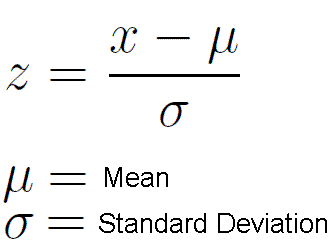


In [15]:
# Lista de columnas continuas a normalizar
columnasNormalizar = [
    'age', 'income', 'bmi', 'visits_last_year', 'days_hospitalized_last_3yrs', 'medication_count', 'systolic_bp', 'diastolic_bp', 'ldl', 'hba1c', 
    'deductible', 'copay', 'annual_medical_cost', 'annual_premium', 'monthly_premium', 'claims_count', 'avg_claim_amount', 'total_claims_paid'
]

# Aplicamos la fórmula del z-score: (valor - media) / desviacionEstandar
#
# Si lo hacemos de la siguiente manera, estaremos usando la vectorización que usa pandas por dentro,
# por lo que ésta operación se vuelve bastante más ligera
data[columnasNormalizar] = (data[columnasNormalizar] - data[columnasNormalizar].mean()) / data[columnasNormalizar].std()

# Comprobamos los datos
data.head()

,age,income,household_size,dependents,bmi,visits_last_year,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,medication_count,systolic_bp,...,marital_status_Single,marital_status_Widowed,employment_status_Employed,employment_status_Retired,employment_status_Self-employed,employment_status_Unemployed,plan_type_EPO,plan_type_HMO,plan_type_POS,plan_type_PPO
person_id,,,,,,,,,,,,,,,,,,,,,
75722,0.234212,-0.580636,3,1,0.081982,0.041635,0,-0.271921,2.285245,0.207625,...,0,0,0,1,0,0,0,0,0,1
80185,2.071429,-0.792174,3,1,-0.078182,0.041635,0,-0.271921,1.458360,0.858278,...,0,0,1,0,0,0,0,0,1,0
19865,1.322933,-0.196023,5,3,0.902822,-0.533829,0,-0.271921,2.285245,2.745170,...,0,0,0,1,0,0,0,1,0,0
76700,-0.106014,-0.732345,5,3,0.922842,-1.109292,0,-0.271921,-0.195409,-0.898484,...,0,0,0,0,1,0,0,1,0,0
92992,0.302257,0.848844,2,0,0.702617,0.617098,0,-0.271921,0.631475,1.183604,...,0,0,0,0,1,0,0,0,1,0


___
## Implementación

Ahora, pasaremos a **implementar el algoritmo de regresión logística**. Para ello, primero **inicializaremos las funciones necesarias**.

### Funciones

#### Función sigmoide
Convertiremos los inputs en valores del 0 a 1.

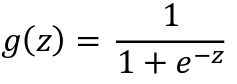

Ésto permite interpretar los números devueltos como probabilidades, y también nos permitirá saber si un caso se "activa" o no, de la siguiente forma:
- y = 1 si `sigmoid(z) >= 0.5`
- y = 1 si `sigmoid(z) < 0.5`



In [16]:
def sigmoide(z):
    return 1/(1+np.exp(-z))

#### Función de coste
Para nuestra función de coste, necesitamos el siguiente comportamiento:
- y=1, h=1: No hay error
- y=0, h=1: Error máximo
- y=1, h=0: Error máximo
- y=0, h=0: No hay error

Básicamente, si nuestro modelo acierta, queremos coste 0, y si falla, queremos coste máximo.

Haciendo uso de algunos cambios en la función de "Entropía cruzada", podemos obtener una función con el comportamiento deseado:

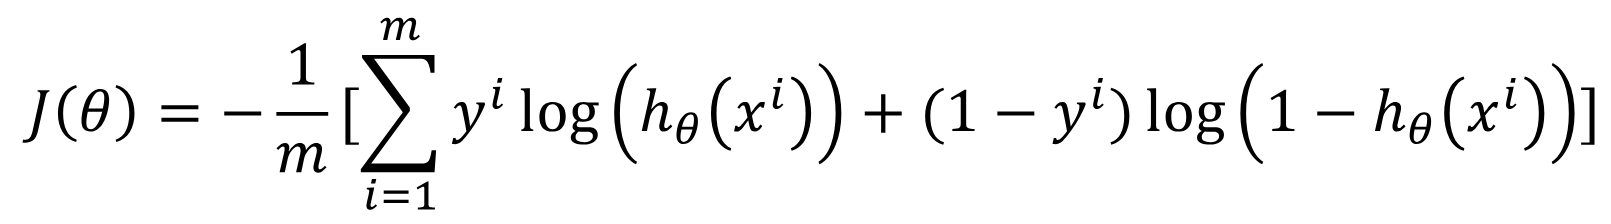

##### Corregir la implementación
Hemos tenido un error a la hora de lanzar la función de coste, y es que el logaritmo, debido a los inputs, terminaban recibiendo un 0. Debido a ésto, ocurre un overflow, ya que `log(0) = -Infinito`.

Hemos añadido un número muy pequeño llamado epsilon, el cual usaremos para limitar los valores de la hipóstesis. De ésta manera, la hipótesis se moverá entre `(0, 1)`, en vez de entre `[0, 1]`.

In [17]:
def coste(X, y, zeta):
    m = len(y)

    # CORRECIÓN
    # Delimitamos la hipóstesis a (0,1)
    epsilon = 1e-15
    h_sin_delimitar = sigmoide(np.dot(X, zeta))
    h = np.clip(h_sin_delimitar, epsilon, 1-epsilon)
    
    sumando1 = np.dot(y.T, np.log(h))
    sumando2 = np.dot((1 - y).T, np.log(1 - h))
    
    coste = (-1/m) * (sumando1+sumando2)
    return coste

#### Descenso de gradiente
Para optimizar los zetas, vamos a utilizar la función de descenso de gradiente:

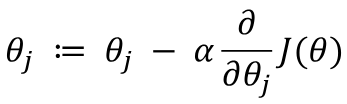

Que teniendo en cuenta la definición de la función de coste, se nos quedaría en:

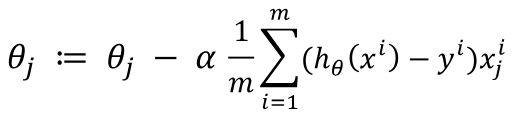

In [18]:
def descensoGradiente(X_entr, y_entr, X_val, y_val, zeta, tasa_aprendizaje, numIter, iterHistorial):
    m = len(y_entr)
    
    historial_entr = []
    historial_val = []
    
    for i in range(numIter):
        # Predecimos y aplicamos el gradiente
        h = sigmoide(np.dot(X_entr, zeta))
        
        gradiente = (1/m) * np.dot(X_entr.T, (h - y_entr))
        
        # Actualizamos zeta en función de la tasa de aprendizaje
        zeta = zeta - (tasa_aprendizaje * gradiente)
        
        # Añadimos datos al historial tras un número
        # concreto de operaciones
        if i % iterHistorial == 0:
            # Coste con los datos de entrenamiento
            coste_entr = coste(X_entr, y_entr, zeta)

            # Para tener más perspectiva, vamos además a
            # calcular el desempeño del modelo en datos
            # que no se están usando para entrenar.
            coste_val = coste(X_val, y_val, zeta) 

            # Guardamos todo el su sitio
            historial_entr.append(coste_entr)
            historial_val.append(coste_val)
            
            print("[ITERACION ", i,"]\ncoste_entr:", coste_entr, "\ncoste_val:",coste_val)
            
    return zeta, historial_entr, historial_val

#### Funciones de visualización de gráficos
Además, vamos a añadir funciones que nos permitan visualizar los datos que vamos recogiendo del entrenamiento:

In [19]:
def plot_historial(titulo, titulo_x, titulo_y, historial):
    sns.set(style="whitegrid")

    plt.figure(figsize=(10, 6))
    plt.plot(historial, color='blue', linewidth=2)
    
    plt.title(titulo, fontsize=16)
    plt.xlabel(titulo_x, fontsize=12)
    plt.ylabel(titulo_y, fontsize=12)
    plt.legend()
    plt.show()

### Entrenamiento

Ahora que ya tenemos todas las funciones implementadas, tenemos que entrenar el modelo haciendo uso de las mismas.

Primero, vamos a dividir el dataset en datos de entrenamiento y datos de prueba (*test*), mediante *hold-out*. En concreto, usaremos el 70% del dataset para entrenamiento y el 30% para test. 
Tambien subdividiremos los datos de entrenamiento en un conjunto de entrenamiento y uno de validación, con el mismo ratio 70% - 30%:

In [20]:
# Barajamos los datos en base a un random state.
# Así, podemos probar distintos conjuntos de entrenamietno y
# validación con sólo cambiar ese valor.
# frac=1 sirve para tomar el dataset entero (fracción entera = 1)
data_random = data.sample(frac=1, random_state=42).reset_index(drop=True)

columna_objetivo = 'is_high_risk'

X = data_random.drop(columns=[columna_objetivo]).values
y = data_random[columna_objetivo].values

# Añadimos la columna de sesgo (bias) al dataset, al principio del mismo.
m_total = len(y)
# np.c_ nos ayuda a concatenar datasets (y arrays, series y demás),
# así que lo usamos para la columna llena de unos que tendrá el bias
X = np.c_[np.ones((m_total, 1)), X]

# Corte 1: Del total, 70% para el total de entrenamiento, 
# 30% para el conjunto de pruebas.

# Calculamos los índices por los que vamos a hacer el corte 70%-30%
corte_total_entr = int(0.7 * m_total)
corte_pruebas = m_total - corte_total_entr # El resto

# Separamos el conjunto total de entrenamiento
# del de test
X_total_entr = X[:corte_total_entr]
y_total_entr = y[:corte_total_entr]

X_test = X[corte_total_entr:]
y_test = y[corte_total_entr:]

# Corte 2: Del conjunto total de entrenamiento, 70% para entrenar,
# 30% para validar
corte_entr = int(0.7 * len(y_total_entr))
corte_val = len(y_total_entr) - corte_entr

X_entr = X_total_entr[:corte_entr]
y_entr = y_total_entr[:corte_entr]

X_val = X_total_entr[corte_entr:]
y_val = y_total_entr[corte_entr:]

print("[DIMENSIONES DE LOS CONJUNTOS]")
print("- Entrenamiento:", X_entr.shape)
print("- Validación:", X_val.shape)
print("- Pruebas/Test:",X_test.shape)

[DIMENSIONES DE LOS CONJUNTOS]
- Entrenamiento: (49000, 70)
- Validación: (21000, 70)
- Pruebas/Test: (30000, 70)


Ahora, entrenaremos a nuestro modelo:

In [21]:
# Inicializamos los parámetros
num_columnas = X_entr.shape[1];
zeta_inicial = np.zeros(num_columnas)

tasa_aprendizaje = 0.2
numIter = 1000
iterHistorial = 100

print("[ -ENTRENANDO- ]")
zeta_optimo, hist_coste_entr, hist_coste_val = descensoGradiente(X_entr, y_entr, X_val, y_val, zeta_inicial, tasa_aprendizaje, numIter, iterHistorial)

[ -ENTRENANDO- ]
[ITERACION  0 ]
coste_entr: 0.7331160491400804 
coste_val: 0.7204297220510304
[ITERACION  100 ]
coste_entr: 0.2430879635304862 
coste_val: 0.2372018451778896
[ITERACION  200 ]
coste_entr: 0.2073716532348546 
coste_val: 0.2024214489459894
[ITERACION  300 ]
coste_entr: 0.19078819333492664 
coste_val: 0.18630653000170566
[ITERACION  400 ]
coste_entr: 0.18090754044256796 
coste_val: 0.17670923089025617
[ITERACION  500 ]
coste_entr: 0.1742094531049225 
coste_val: 0.17020380017865216
[ITERACION  600 ]
coste_entr: 0.16928749916586336 
coste_val: 0.16542299965250917
[ITERACION  700 ]
coste_entr: 0.16546401269439767 
coste_val: 0.16170823781983643
[ITERACION  800 ]
coste_entr: 0.16237051758159224 
coste_val: 0.158701472609812
[ITERACION  900 ]
coste_entr: 0.1597887654234501 
coste_val: 0.15619068962321503


Acompañemos los resultados con una gráfica para ver el decrecimiento del coste:

/tmp/ipykernel_61978/2847231274.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


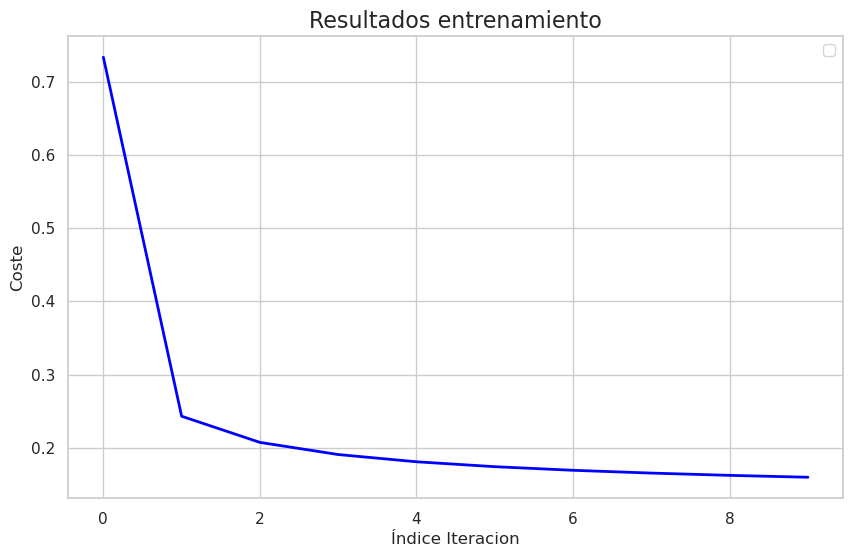

In [22]:
plot_historial('Resultados entrenamiento', 'Índice Iteracion', 'Coste', hist_coste_entr)

### Prueba de calidad
Para finalizar, comprobamos el rendimiento del modelo en los datos de validación o test.

#### Ejecutar en conjunto de test
Usaremos el conjunto de prueba para probar la calidad de nuestro modelo, asegurándonos que funcione en datos nunca vistos:

In [23]:
coste_test = coste(X_test, y_test, zeta_optimo)
print("[ -RESULTADOS- ]")
print("Coste final en datos de prueba:",coste_test)

[ -RESULTADOS- ]
Coste final en datos de prueba: 0.15521383394435875


#### Precisión
Calculemos la precisión del algoritmo, en porcentaje de aciertos.

In [24]:
probabilidad_prediccion = sigmoide(np.dot(X_test, zeta_optimo))
valores_predichos = (probabilidad_prediccion >= 0.5).astype(int)

# Contrastamos los valore
precision = np.mean(valores_predichos == y_test)
print("Precisión datos de prueba:", precision * 100)

Precisión datos de prueba: 93.61333333333334
